## Sprint24 Seq2Seq

#### 1.このSprintについて

##### Sprintの目的
系列データに関する応用例を学ぶ

##### どのように学ぶか
公開されているコードを元に学んでいきます。

#### 2.機械翻訳
系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。

### 【問題1】機械翻訳の実行とコードリーディング 
Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。
keras/lstm_seq2seq.py at master · keras-team/keras
その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。
##### （例）
51から55行目 : ライブラリのimport  
57から62行目 : ハイパーパラメータの設定

##### 《文字単位のトークン化》
この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。

scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。

charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。

sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation  
コメントで記述

In [0]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = r'C:\Users\anai\dive\TEST_upload3\diveintocode-ml\Sprint24_datasets/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


W1030 13:32:12.358598  2684 deprecation_wrapper.py:119] From C:\Users\anai\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1030 13:32:12.375554  2684 deprecation_wrapper.py:119] From C:\Users\anai\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1030 13:32:12.385527  2684 deprecation_wrapper.py:119] From C:\Users\anai\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1030 13:32:13.007671  2684 deprecation_wrapper.py:119] From C:\Users\anai\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1030 13:32:13.036594  2684 deprecation_wrapper.py:119] From C:\Users\anai\Anaconda3

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 33s 4ms/step - loss: 1.2065 - acc: 0.7229 - val_loss: 1.0914 - val_acc: 0.6983
Epoch 2/100
8000/8000 [==============================] - 31s 4ms/step - loss: 0.8777 - acc: 0.7622 - val_loss: 0.8911 - val_acc: 0.7540
Epoch 3/100
8000/8000 [==============================] - 32s 4ms/step - loss: 0.7002 - acc: 0.8055 - val_loss: 0.7561 - val_acc: 0.7845
Epoch 4/100
8000/8000 [==============================] - 32s 4ms/step - loss: 0.6030 - acc: 0.8246 - val_loss: 0.6643 - val_acc: 0.8053
Epoch 5/100
8000/8000 [==============================] - 32s 4ms/step - loss: 0.5509 - acc: 0.8386 - val_loss: 0.6209 - val_acc: 0.8150
Epoch 6/100
8000/8000 [==============================] - 33s 4ms/step - loss: 0.5119 - acc: 0.8498 - val_loss: 0.5900 - val_acc: 0.8272
Epoch 7/100
8000/8000 [==============================] - 32s 4ms/step - loss: 0.4827 - acc: 0.8575 - val_loss: 0.5589 - val_acc: 0.8354


C:\Users\anai\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Hello!
Decoded sentence: Bonjour !

-
Input sentence: Hello!
De

#### 【回答】
44 ~ 48行目
ライブラリのインポートをしている
(future)はpython2系の関数を使用する時に使う様子
kerasを用いてモデルの構築を行なっている
LSTM,Denseレイヤーを用いている。

50 ~ 55行目
ハイパーパラメータの設定
潜在的な次元数、学習に使うデータ数を設定している

117 ~ 149 行目

モデル構築していいる
モデルはDenseとLSTMのみで構築されている
エンコーダ部分とデコーダ部分を分けて作成している
デコーダの入力にエンコーダの出力を反映させている

160 ~ 171 行目

predict用のモデルを構築している
エンコーダ部分は学習時に使用したものを用いている
デコーダ部分はハイパーパラメータで設定した次元数を元に作成している

181 ~ 216 行目

predictする関数
エンコーダとデコーダを分けて実行して推定している。

#### 3.イメージキャプショニング
他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。

pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

### 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。 データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。 注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import os

os.chdir('/content/drive/My Drive')
print(os.getcwd())

/content/drive/My Drive


In [0]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 816, done.
remote: Total 816 (delta 0), reused 0 (delta 0), pack-reused 816
Receiving objects: 100% (816/816), 12.78 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (432/432), done.


In [13]:
os.chdir('/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning')
print(os.getcwd())

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [8]:
os.chdir('/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/models')
print(os.getcwd())
!unzip "/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/models/pretrained_model.zip"

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/models
Archive:  /content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/models/pretrained_model.zip
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [12]:
os.chdir('/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/data')
print(os.getcwd())
!unzip "/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocap.zip"

/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/data
Archive:  /content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocap.zip
  inflating: vocab.pkl               


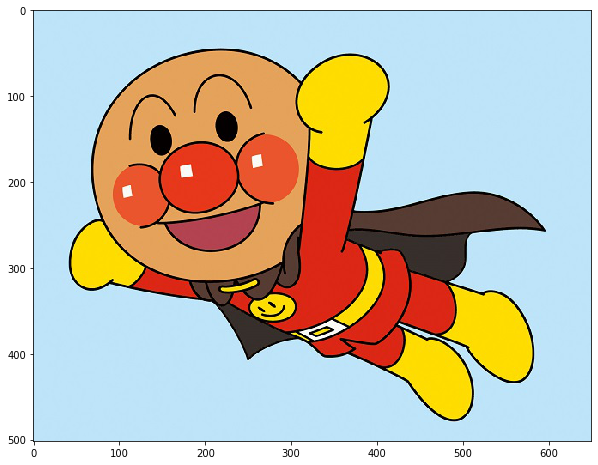

explain!
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100% 230M/230M [00:24<00:00, 9.83MB/s]
<start> a red and white photo of a red and white photo . <end>


In [14]:
import numpy as np
im = Image.open("/content/drive/My Drive/pytorch-tutorial/tutorials/03-advanced/image_captioning/anpanman.jpg")
im_list = np.asarray(im)
plt.figure(figsize=(10, 8))
plt.imshow(im_list)
plt.show()
print("explain!")


!python sample.py --image='anpanman.jpg' --encoder_path='models/encoder-5-3000.pkl' --decoder_path='models/decoder-5-3000.pkl'

### 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。 特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

#### 【回答】
学習済みの重みをONNX形式に変換する
そのあと、kerasへと変換する
もしくはpytorch2kerasのようなgithubのシステムを使い変換する

pytorchがchannels_first,kerasがchannels_lastなので、axis関連の位置を変更する

GPUの使用を明示する必要がない

modelに書かれているエンコーダとデコーダの記述をkerasの書式で書く